In [1]:
import shutil
import os
import pandas as pd
import numpy as np

## Environment

In [2]:
import shutil
import os

app_home = os.getcwd()
from cairn import *

# préparation du répertoire pour la simulation
simuPath = os.path.join(app_home, './results')
dataPath = os.path.join(app_home, './data')

if os.path.exists(simuPath):
	shutil.rmtree(simuPath)
os.makedirs(simuPath)

simuFile = 'cairn_training.json'
simuFull = os.path.join(simuPath, simuFile)
shutil.copy(os.path.join(dataPath, simuFile), simuFull)

cairn_instance = CairnAPI(True)

## CairnAPI
CairnAPI allows the user to create a study, or to read an existing study.

CairnAPI is the main instance where the user can know generic information about Cairn such as the available models (components), the available solvers, and the possible carrier (EnergyVector) types.

In [3]:
print("Components available: ")
for i in range(0, len(cairn_instance.all_models), 6):
        chunk = cairn_instance.all_models[i:i + 6]
        print(', '.join(map(str, chunk)))

Components available: 
Compressor, Converter, Electrolyzer, GridFree, ManualObjective, MinStateTime
MultiConverter, NodeEquality, NodeLaw, Ramp, ResourceStock, SourceLoad
StorageGen


In [4]:
print("Solvers available: ")
print(', '.join(cairn_instance.solvers))

Solvers available: 
Highs


In [5]:
print("Possible carrier types: ")
print(', '.join(cairn_instance.carrier_types))

Possible carrier types: 
Electrical, Thermal, FluidH2, FluidCH4, Fluid, Material


## Model Reading
Below an example of opening an existing study (.json file) and loading a .csv timeseries file (mandatory to run a simulation)

In [6]:
# Run Persee
print(simuFull)
problem = cairn_instance.read_study(simuFull)

problem.add_timeseries(os.path.join(dataPath, 'cairn_training_dataseries.csv'))


C:\Users\sc258201\Documents\03-Sources\apipython\./results\cairn_training.json


## Parameters Reading

The user can get all the EnergyVectors configured in the study and read through all the settings. 


In [7]:
listEV = problem.energy_carriers
for EVname in listEV:
    EV = problem.get_energy_carrier(EVname)
    print(f"{EV.name} is an EnergyVector of type {EV.type}")
    print(f"{EV.name} settings:")
    for i in range(0, len(EV.settings()), 8):
        chunk = EV.settings()[i:i + 8]
        print(', '.join(map(str, chunk)))
    print("")
    print(f"{EV.name} mandatory settings:")
    for i in range(0, len(EV.settings(CairnAPI.ESettingsLimited.mandatory)), 9):
        chunk = EV.settings(CairnAPI.ESettingsLimited.mandatory)[i:i + 9]
        print(', '.join(map(str, chunk)))
    print("")
    print("With the value of each setting:")
    setEV = EV.setting_values
    for i in setEV:
        print(f"{i} : {setEV[i]}")
    print("")
    print("Retrieving the value of one particular parameter:")
    value = EV.get_setting_value("IsFuelCarrier")
    print(f"Is fuel carrier? {value}")
    print("")
    

ElectricityDistrib is an EnergyVector of type Electrical
ElectricityDistrib settings:
EnergyName, EnergyUnit, FlowrateUnit, FluxName, FluxUnit, IsFuelCarrier, IsHeatCarrier, IsMassCarrier
MassUnit, PeakUnit, PotentialName, PotentialUnit, PowerName, PowerUnit, StorageName, StorageUnit
SurfaceUnit, Type, Xpos, Ypos, id, BuyPrice, CP, GHV
LHV, Potential, RHO, SellPrice, UseProfileBuyPrice, UseProfileBuyPriceSeasonal, UseProfileSellPrice

ElectricityDistrib mandatory settings:
EnergyUnit, FlowrateUnit, MassUnit, PeakUnit, PowerUnit, SurfaceUnit, id, BuyPrice, Potential
SellPrice

With the value of each setting:
BuyPrice : 0.0
CP : 0.0
EnergyName : Energy
EnergyUnit : MWh
FlowrateUnit : kg/h
FluxName : ElectricalPower
FluxUnit : MW
GHV : 0.0
IsFuelCarrier : 0
IsHeatCarrier : 0
IsMassCarrier : 0
LHV : 1.0
MassUnit : kg
PeakUnit : MWc
Potential : 220.0
PotentialName : Voltage
PotentialUnit : V
PowerName : Power
PowerUnit : MW
RHO : 0.0
SellPrice : 0.0
StorageName : ElectricalEnergy
StorageUni

Similarly, the user can do the same for the Buses and components

In [8]:
list_bus = problem.buses
print(list_bus)

['Elec_Bus', 'H2_Bus']


In [9]:
list_compo = problem.get_components()
print(list_compo)

['ELY_PEM', 'Elec_Grid', 'Elec_Grid_Inject', 'H2_Load', 'H2_Tank', 'Wind_farm']


Example for ELY_PEM component

In [10]:
compo = problem.get_component("ELY_PEM")
print(compo.name)
df = pd.DataFrame.from_dict(compo.setting_values, orient='index')
print(df)
print("")
print("Retrieving the value of a given parameter:")
value = compo.get_setting_value("Capex")
print(f"Capex : {value}")

ELY_PEM
                                                      0
Acidification#Accumulated Exceedance EnvGreyCon...  0.0
Acidification#Accumulated Exceedance EnvGreyCon...  0.0
Acidification#Accumulated Exceedance EnvGreyRep...  0.0
Acidification#Accumulated Exceedance EnvGreyRep...  0.0
Acidification#Accumulated Exceedance PiecewiseE...    0
...                                                 ...
Weight                                              1.0
WeightUnit                                            -
Xpos                                                480
Ypos                                                234
submodelfile                                           

[79 rows x 1 columns]

Retrieving the value of a given parameter:
Capex : 480000.0


Note, the user can modify the parameters of a Bus or a componenet using compo.setting_values = dict{paramName: paramValue}.

## Modifying Problem

The following example shows how to create a component. To create a component the user has to provide a component name and a component model from the list of possible models (given by persee_instance.all_models). The user can choose any name, but two componenets cannot have the same name.

In [12]:
myPV = Component("PV", "SourceLoad")

Similarly, the user can crate an EnergyVector by providing an EnergyVector name (any unique name) and a carrier type (from persee_instance.carrier_types). Note, to create a Bus, the user has to additionally provide an EnergyVector (the object, not the name) as a 3rd argument. Available Bus models are NodeLaw, NodeEquality and MultiObjective. 

A component can be configured by modifying its parameters as follows:

In [13]:
myPV.set_setting_value("Capex", 1000)

In [14]:
myPV.setting_values = {
		"Direction": "Source" ,
		"Weight": 1,
		"Opex": 0 ,
		"MaxFlow": -10,
		"EcoInvestModel": 1,
        "UseProfileLoadFlux":"PVProduction"
		}

It is mandatory to add port(s) to the component in order to connect it to the energy system and in particular to one or several buses previously created

In [15]:
elec_carrier=problem.get_energy_carrier("ElectricityDistrib")
myPV_R0 = Port("PortR0", elec_carrier)
myPV_R0.setting_values = {
				"Direction": "OUTPUT",
				"Variable": "SourceLoadFlow"
		}

Do not forget to add the port(s)

In [16]:
myPV.add_port(myPV_R0)

Before adding the component to the problem

In [17]:
problem.add_component(myPV)

Then link the component to a bus

In [18]:
print(problem.buses)
elec_bus = problem.get_bus("Elec_Bus")
problem.add_link(myPV_R0, elec_bus)

['Elec_Bus', 'H2_Bus']


## Run a simulation

In [22]:
problem.save_study(simuFull)
sol = problem.run()

## Solutions


It is then possible to access information about the resolution

In [24]:
print(sol.status)

Optimal


Also to access indicators

In [25]:
ely_pem = problem.get_component("ELY_PEM")
print("Use the following method to access the name of all the indicators of a component:")
indicators = ely_pem.indicators
print(indicators)
print("")
print("You can aslo access directly to the value of an indicator:")
print(ely_pem.get_indicator_value("Total Cost Function", "PLAN"))
print("")
print("Or even create easily a dataframe of indicators:")
ind = ely_pem.get_indicators_values("PLAN")
df = pd.DataFrame([ind]).transpose()
print(df)

Use the following method to access the name of all the indicators of a component:
['Total Cost Function', 'Capex part', 'is installed', 'Opex part (including energy cost)', 'Pure Opex part', 'Replacement part', 'Mass', 'Area', 'Volume', 'Climate change#Global Warming Potential 100 Env impact penalty part', 'Climate change#Global Warming Potential 100 Env impact mass', 'Climate change#Global Warming Potential 100 EnvGrey impact cost', 'Climate change#Global Warming Potential 100 EnvGrey impact mass', 'Climate change#Global Warming Potential 100 Env grey impact replacement part', 'Acidification#Accumulated Exceedance Env impact penalty part', 'Acidification#Accumulated Exceedance Env impact mass', 'Acidification#Accumulated Exceedance EnvGrey impact cost', 'Acidification#Accumulated Exceedance EnvGrey impact mass', 'Acidification#Accumulated Exceedance Env grey impact replacement part', 'Sum up at', 'Installed Size', 'Running time at power >0.', 'Running time availability', 'PROD Total F

Also to access to the results of Inputs/Outputs of each component

In [26]:
ely_pem = problem.get_component("ELY_PEM")
print("Use the following method to access the name of all the IO expressions of a component:")
variables = ely_pem.variables
print(variables)

Use the following method to access the name of all the IO expressions of a component:
['Acidification#Accumulated Exceedance Env grey impact cost', 'Acidification#Accumulated Exceedance Env grey impact mass', 'Acidification#Accumulated Exceedance Env grey impact replacement part', 'Acidification#Accumulated Exceedance Env impact cost', 'Acidification#Accumulated Exceedance Env impact flow', 'Acidification#Accumulated Exceedance Env impact mass', 'Capex', 'Climate change#Global Warming Potential 100 Env grey impact cost', 'Climate change#Global Warming Potential 100 Env grey impact mass', 'Climate change#Global Warming Potential 100 Env grey impact replacement part', 'Climate change#Global Warming Potential 100 Env impact cost', 'Climate change#Global Warming Potential 100 Env impact flow', 'Climate change#Global Warming Potential 100 Env impact mass', 'H2MassFlowRate', 'MaxPower', 'MaxUsablePower', 'Opex', 'PureOpex', 'Replacement', 'SizeMax', 'UsedPower', 'VariableCosts', 'isInstalled

[36.93299894716415, 43.84560863439346, 46.54468196709186, 49.70078525566109, 53.49427271146876, 56.14482222764479, 56.1448222276448, 56.1448222276448, 56.1448222276448, 56.1448222276448, 56.1448222276448, 56.1448222276448, 56.14482222764481, 56.14482222764481, 56.144822227644795, 33.597618988027506, 18.845799798403036, 30.978099413278716, 41.08824911023101, 45.35210966133698, 42.8698325285963, 39.262388127119166, 36.284728457375294, 32.86052681604066, 26.683166091825633, 13.33105809011665, 2.8225101931702596, 0.819828909131981, 1.0206593027380868, 3.4880496607143043, 12.80058004328755, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
                                      H2MassFlowRate  \
0  [36.93299894716415, 43.84560863439346, 46.5446...   

                                                Time  
0  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  


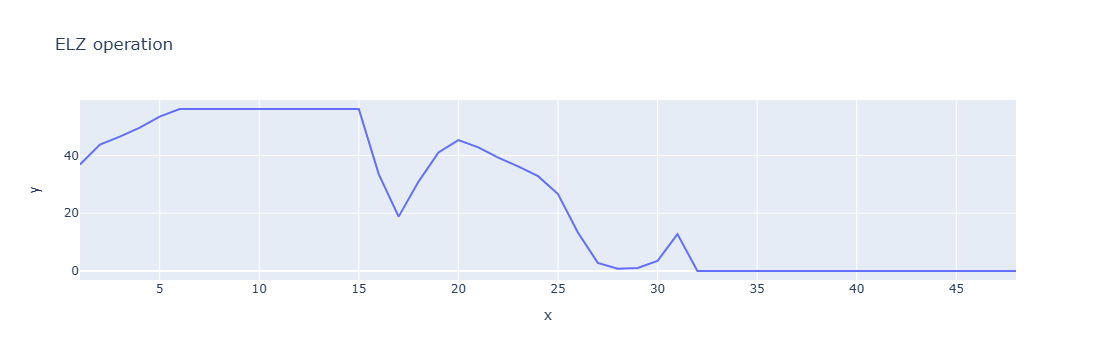

In [49]:
import plotly.express as px

times = np.arange(1, 49).tolist()
print(ely_pem.get_var_value("H2MassFlowRate"))
df = pd.DataFrame(data=[[ely_pem.get_var_value("H2MassFlowRate"), times]], columns=["H2MassFlowRate", "Time"])

print(df)

df = pd.DataFrame(dict(
    x = times,
    y = ely_pem.get_var_value("H2MassFlowRate")
))

fig = px.line(df, x="x", y="y", title='ELZ operation')
fig.show()